# (11.2B) Application of filter with new distance - burst size volume dependence - greater width

In this notebook we use the new objective function $D_{new} = D_{HD}\times D_{euc}$ in combination with the averaging filter designed in notebook 10. The filter width will be chosen so that the autocorrelation function of the artificial experimental lineage is $1/e$.

Let's start by importing the SSA and the experimental data (only to be used to given initial volumes, molecule numbers and exponential growth rates) and processing it as was done in notebook 5:

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## Second attempt at inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\alpha_0 = 5.0$, $\alpha_1 = 0.0$, $\beta_0 = 1.0$ and $\beta_1 = 1.0$:

In [4]:
true_par = [5.0,0.000001,1.0,1.0];

In [5]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_c = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        push!(SSA_data_c, ssa[2][:]);
    end
    return convert(Array{Array{Float64,1},1},SSA_data_c) # return 
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [6]:
expt_ssa_conc = Single_lin(lineage_data, true_par, v0_n0_th[1]);

Let's plot this data:

In [7]:
using GpABC, LambertW, Distances, Plots, Distributions, LaTeXStrings, StatsBase, Statistics, LinearAlgebra; pyplot()

Plots.PyPlotBackend()

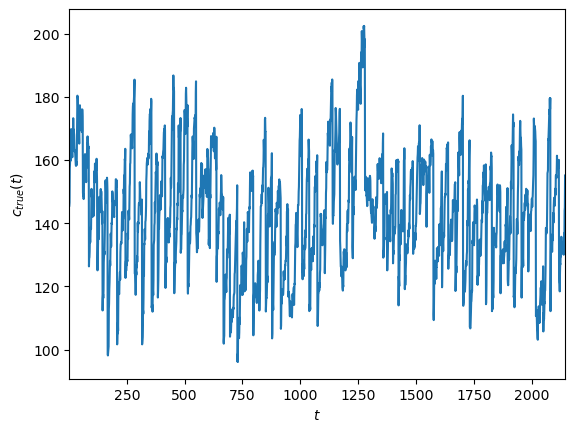

In [8]:
PyPlot.plot(range(1,length(vcat(expt_ssa_conc...)[:]),step=1),vcat(expt_ssa_conc...)[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(vcat(expt_ssa_conc...)[:])]);

Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.


0.99

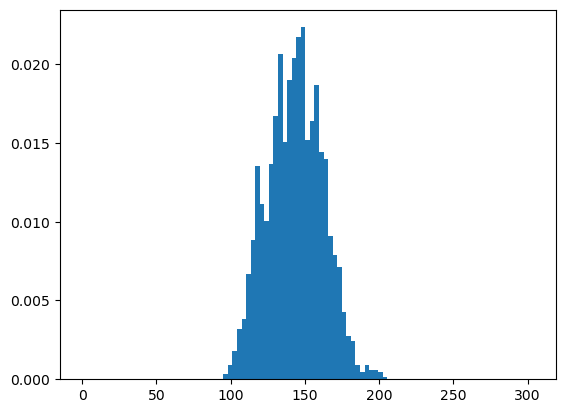

In [9]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0.0, maximum(vcat(expt_ssa_conc...)[:])*1.5, 100);
true_bin_vals, other_stuff = ax.hist(vcat(expt_ssa_conc...)[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals*(maximum(vcat(expt_ssa_conc...)[:])*1.5/100))) # check the sum of bins is 1.

true_bin_vals_form = convert(Array{Float64,2},transpose(true_bin_vals));

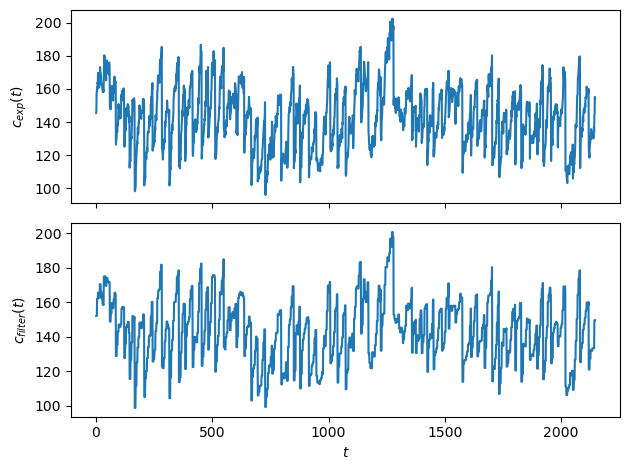

In [10]:
n = 4;

lin_expt = vcat(expt_ssa_conc...); filter_expt = filter_lin(expt_ssa_conc, n)[2]
filter_expt_form = hcat(filter_expt);

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{filter}(t)"); 
axs[1].plot(range(1,length(lin_expt),step=1),lin_expt); axs[2].plot(range(1,length(filter_expt),step=1),filter_expt);

In [11]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    lin_conc = filter_lin(Single_lin(lineage_data, var_params, lin_ic)[:], n)[2] # choose up-sep form [2]
    return hcat(lin_conc)::Array{Float64,2}
end

simulator_function_conc (generic function with 1 method)

Create the new distance function that takes in the sample trajectory vector and experimental trajectory as inputs and outputs the product of the hellinger distance and the euclidean distance between the two trajectories.

In [12]:
function new_distance(samp_traj::Array{Float64,1}, exp_traj::Array{Float64,1})
    euc_dist = euclidean(samp_traj[:], exp_traj[:]); # euclidean distance
    samp_bins = normalize(fit(Histogram, samp_traj[:], mod_bins), mode=:probability).weights;
    exp_bins = normalize(fit(Histogram, exp_traj[:], mod_bins), mode=:probability).weights;
    hell_dist = hellinger(samp_bins, exp_bins); # HD
    
    return euc_dist*hell_dist::Float64 # return the product
end

new_distance (generic function with 1 method)

In [13]:
thres_cutoff = sum(new_distance(simulator_function_conc(true_par)[:], filter_expt_form[:]) for i in 1:1000)/1000

81.608735388433

In [14]:
@time new_distance(simulator_function_conc(true_par)[:], filter_expt_form[:])

  0.006382 seconds (18.34 k allocations: 1.581 MiB)


61.95942197912514

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 207/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 393/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 134/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 270/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 411/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 150.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm

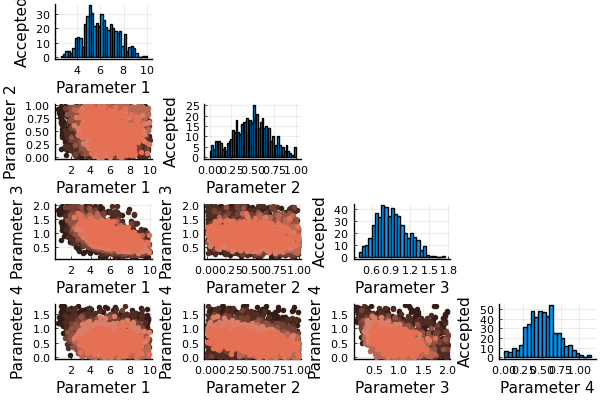

In [15]:
n_particles = 500;
threshold_schedule = [500.0, 250.0, 150.0, 110.0, 100.0, 95.0, 90.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.0), Uniform(0, 2.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053"]#,"#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

In [16]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 5.968675525667832
 0.4911975722793722
 0.8954769810175276
 0.5048126311926107

In [17]:
true_par

4-element Array{Float64,1}:
 5.0
 1.0e-6
 1.0
 1.0

Print the differences.

In [18]:
diff = (pars_conc_1 - true_par)

4-element Array{Float64,1}:
  0.9686755256678321
  0.49119657227937225
 -0.1045230189824724
 -0.49518736880738934

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

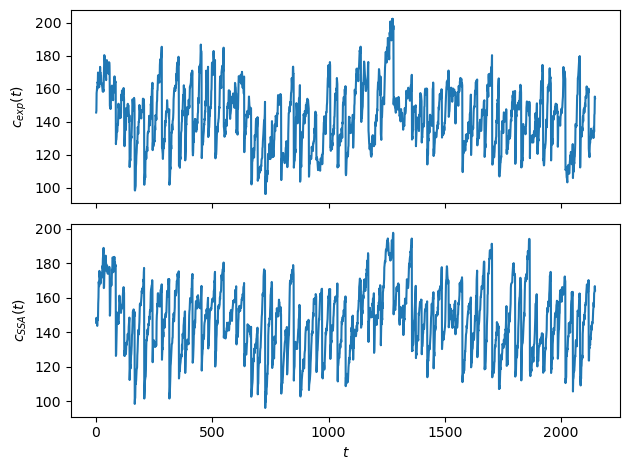

  0.008650 seconds (23.09 k allocations: 2.180 MiB)


In [19]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(expt_ssa_conc...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

The inability to infer parameters here seems to arise from the indistinguishability of parameter sets with respect to this objective function of the HD. This is also shown above by the similarity of the behaviour in the concentration trajectories.

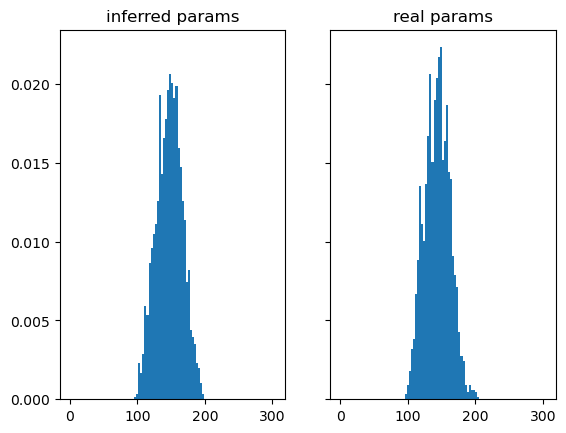

Hellinger distance between these is: 0.10283165367523446

In [20]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

## Run them again!

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 195/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 393/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 136/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 269/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 402/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 150.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm

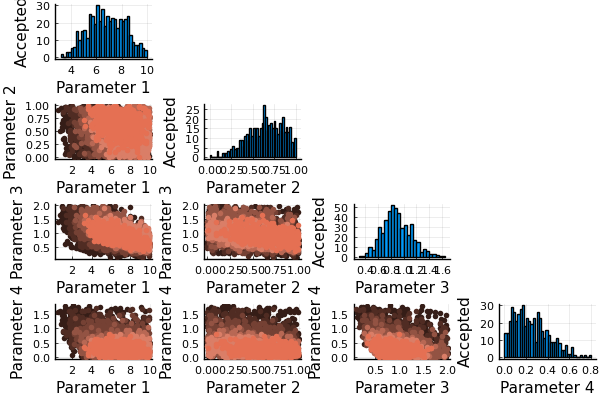

In [21]:
n_particles = 500;
threshold_schedule = [500.0, 250.0, 150.0, 110.0, 100.0, 95.0, 90.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.0), Uniform(0, 2.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

In [22]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 6.79127037508071
 0.6557601677251117
 0.8671202478756365
 0.22199252827884008

In [23]:
true_par

4-element Array{Float64,1}:
 5.0
 1.0e-6
 1.0
 1.0

Print the differences.

This is the worst inference of the three runs, so let's have a look at the evolution of the intermediate posteriors and see if the transitions between them are smooth. 

In [24]:
diff_2 = (pars_conc_2 - true_par)

4-element Array{Float64,1}:
  1.7912703750807104
  0.6557591677251117
 -0.13287975212436354
 -0.7780074717211599

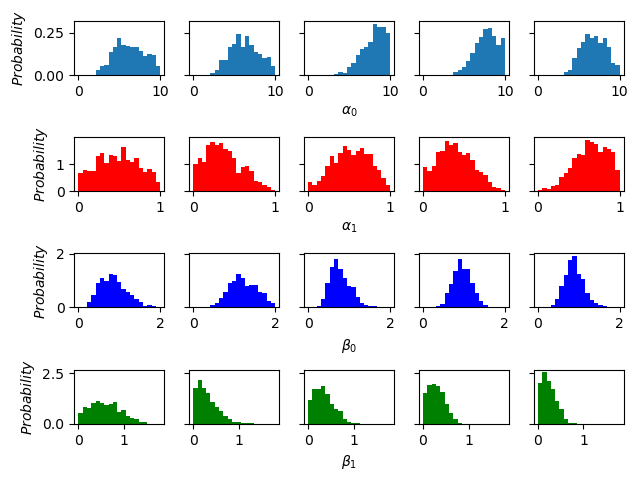

In [75]:
fig, ax = PyPlot.subplots(4,5, sharey="row");
post_bins = [LinRange(0.0, 10.0, 20), LinRange(0.0, 1.0, 20), LinRange(0.0, 2.0, 20), LinRange(0.0, 1.8, 20)];
posts = [ones(20) for i in 1:20];

for i in 1:5
    posts[4*i-3], os = ax[4*i-3].hist(sim_abcsmc_res_conc_2.population[end-5+i][:,1], bins = post_bins[1], density = true);
    posts[4*i-2], os = ax[4*i-2].hist(sim_abcsmc_res_conc_2.population[end-5+i][:,2], bins = post_bins[2], density = true, color = "r");
    posts[4*i-1], os = ax[4*i-1].hist(sim_abcsmc_res_conc_2.population[end-5+i][:,3], bins = post_bins[3], density = true, color = "b");
    posts[4*i], os = ax[4*i].hist(sim_abcsmc_res_conc_2.population[end-5+i][:,4], bins = post_bins[4], density = true, color = "g");
end

ax[1].set_ylabel(L"Probability");ax[2].set_ylabel(L"Probability");ax[3].set_ylabel(L"Probability");ax[4].set_ylabel(L"Probability")
ax[9].set_xlabel(L"\alpha_0");ax[10].set_xlabel(L"\alpha_1");ax[11].set_xlabel(L"\beta_0");ax[12].set_xlabel(L"\beta_1");
fig.tight_layout()


In [80]:
using DataFrames;
HD_a0 = [hellinger(posts[4*i-3],posts[4*(i+1)-3]) for i in 1:4];
HD_a1 = [hellinger(posts[4*i-2],posts[4*(i+1)-2]) for i in 1:4];
HD_b0 = [hellinger(posts[4*i-1],posts[4*(i+1)-1]) for i in 1:4];
HD_b1 = [hellinger(posts[4*i],posts[4*(i+1)]) for i in 1:4];
df = DataFrame(HDs_alpha_0 = HD_a0 , HDs_alpha_1 = HD_a1, HDs_beta_0 = HD_b0, HDs_beta_1 = HD_b1)

,HDs_alpha_0,HDs_alpha_1,HDs_beta_0,HDs_beta_1
,Float64,Float64,Float64,Float64
1,0.0886285,0.196654,0.407765,0.344885
2,0.372657,0.256177,0.497836,0.109596
3,0.10509,0.222949,0.284794,0.127447
4,0.237074,0.41202,0.124453,0.110119


And again...

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 180/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 355/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 250.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 128/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 266/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 392/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 150.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm

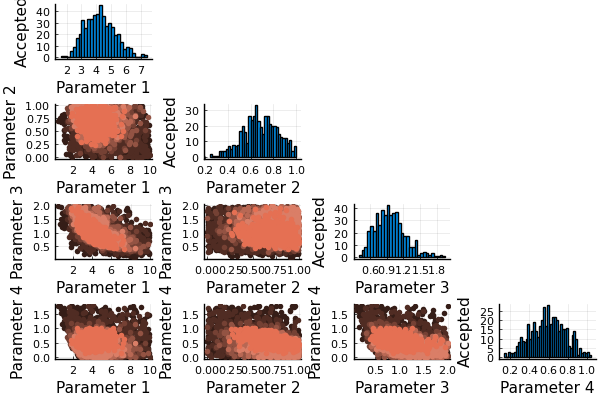

In [25]:
n_particles = 500;
threshold_schedule = [500.0, 250.0, 150.0, 110.0, 100.0, 95.0, 90.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.0), Uniform(0, 2.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_3This is the worst inference of the three runs, so let's have a look at the evolution of the intermediate posteriors and see if the transitions between them are smooth. 

fig, ax = PyPlot.subplots(2,5, sharex=true, sharey=true);
for i in 1:5
    ax[i].hist(sim_abcsmc_res_conc_3.population[end-5+i][:,1], bins = mod_bins, density = true);
    ax[i+5].hist(sim_abcsmc_res_conc_3.population[end-5+i][:,2], bins = mod_bins, density = true);
end = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_3, population_colors=population_colors)

In [26]:
pars_conc_3 = [median(sim_abcsmc_res_conc_3.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 4.187440988224278
 0.6795702137866932
 0.9401645452829749
 0.5940919701280457

In [27]:
true_par

4-element Array{Float64,1}:
 5.0
 1.0e-6
 1.0
 1.0

Print the differences.

In [28]:
diff_3 = (pars_conc_3 - true_par)

4-element Array{Float64,1}:
 -0.812559011775722
  0.6795692137866932
 -0.059835454717025116
 -0.4059080298719543

## Summary of results

The model that we are attempting to infer the parameter for is:
$$\varnothing \xrightarrow{a_1(t)}m\, P\xrightarrow{d}\varnothing,$$
where $a_1(t) = \alpha_0 V(t)^{\alpha_1}$ and $m$ is a random number drawn from a geometric distribution with time-dependent mean burst size $b(t) = \beta_0 V(t)^{\beta_1}$ and degradation rate $d = 0$. The volume of the system grows according to exponential growth law: $V(t) = V_0 e^{\theta t}$. Later on in this sheet we also go onto assess the minimum threshold for the SMC-ABC data. 

Let's see the inferred medians of the posterior distributions in some tables.

In [29]:
using DataFrames;

In [30]:
par_conc = convert(Array{Float64,2},transpose([true_par pars_conc_1 pars_conc_2 pars_conc_3]));
df_conc = DataFrame(alpha_0 = par_conc[:,1], alpha_1 = par_conc[:,2], beta_0 = par_conc[:,3], beta_1 = par_conc[:,4]);

In [31]:
df_conc

,alpha_0,alpha_1,beta_0,beta_1
,Float64,Float64,Float64,Float64
1,5.0,1.0e-6,1.0,1.0
2,5.96868,0.491198,0.895477,0.504813
3,6.79127,0.65576,0.86712,0.221993
4,4.18744,0.67957,0.940165,0.594092
